In [2]:
import numpy as np
import pandas as pd
import unicodedata
import re
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [3]:

data = pd.read_csv('output.csv')
 

In [4]:
data.head()


,province,district,street,price_unit,price_value,price_absolute,area,type,front,room,toilet,floor,attributes
0,1,5,Mặt phố C1 TT Nghĩa Tân,1,5.50,5500.0,70.0,1,7.0,2,2,1,"Ô tô, Kinh doanh, Dòng tiền"
1,1,5,Yên Hoà,1,8.58,8580.0,45.0,1,5.0,5,4,4,Ô tô
2,1,5,Cầu Giấy,1,8.65,8650.0,43.0,1,3.6,6,1,5,NaN
3,1,5,Hồ Tùng Mậu,1,28.50,28500.0,100.0,1,6.9,29,29,8,"Ô tô, Dòng tiền, Thang máy"
4,1,5,Cầu Giấy,1,8.90,8900.0,35.0,1,3.4,6,2,5,NaN


In [5]:
print(data['attributes'])


0      Ô tô, Kinh doanh, Dòng tiền
1                             Ô tô
2                              NaN
3       Ô tô, Dòng tiền, Thang máy
4                              NaN
                  ...             
546                           Ô tô
547      Ô tô, Mặt phố, Kinh doanh
548                            NaN
549                           Ô tô
550      Ô tô, Mặt phố, Kinh doanh
Name: attributes, Length: 551, dtype: object


In [9]:
# 1. Loại bỏ khoảng trắng và điền NaN
data['attributes'] = data['attributes'].str.strip()
data['attributes'] = data['attributes'].fillna('Không rõ')  # Loại bỏ inplace=True

# 2. Mã hóa các thuộc tính
attributes_dummies = data['attributes'].str.get_dummies(sep=', ')

# 3. Ghép các cột đã mã hóa vào DataFrame gốc
data = pd.concat([data, attributes_dummies], axis=1)

# 4. Kiểm tra kết quả
print(data.head())


   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  street_xx cau giay  \
0          5500.0   70.0     1    7.0     2  ...               False   
1          8580.0   45.0     1    5.0     5  ...               False   
2          8650.0   43.0     1    3.6     6  ...               False   
3         28500.0  100.0     1    6.9    29  ...               False   
4          8900.0   35.0     1    3.4     6  ...               False   

   street_xx tran thai tong street_yen hoa  Chung cư  Dòng tiền  Không rõ  \
0                     False          Fa

In [7]:
data.head()

,province,district,street,price_unit,price_value,price_absolute,area,type,front,room,toilet,floor,attributes,Chung cư,Dòng tiền,Không rõ,Kinh doanh,Mặt phố,Thang máy,Ô tô
0,1,5,Mặt phố C1 TT Nghĩa Tân,1,5.50,5500.0,70.0,1,7.0,2,2,1,"Ô tô, Kinh doanh, Dòng tiền",0,1,0,1,0,0,1
1,1,5,Yên Hoà,1,8.58,8580.0,45.0,1,5.0,5,4,4,Ô tô,0,0,0,0,0,0,1
2,1,5,Cầu Giấy,1,8.65,8650.0,43.0,1,3.6,6,1,5,Không rõ,0,0,1,0,0,0,0
3,1,5,Hồ Tùng Mậu,1,28.50,28500.0,100.0,1,6.9,29,29,8,"Ô tô, Dòng tiền, Thang máy",0,1,0,0,0,1,1
4,1,5,Cầu Giấy,1,8.90,8900.0,35.0,1,3.4,6,2,5,Không rõ,0,0,1,0,0,0,0


In [8]:
# Import các thư viện cần thiết
import pandas as pd
import re
import unicodedata

# Hàm chuẩn hóa tên đường
def normalize_street_name(street_name):
    # Loại bỏ dấu tiếng Việt
    street_name = unicodedata.normalize('NFKD', street_name).encode('ascii', 'ignore').decode('utf-8')
    # Chuyển thành chữ thường
    street_name = street_name.lower()
    # Loại bỏ các ký tự đặc biệt và khoảng trắng thừa
    street_name = re.sub(r'[^a-z0-9\s]', '', street_name)
    street_name = re.sub(r'\s+', ' ', street_name).strip()
    return street_name

# Áp dụng hàm chuẩn hóa lên cột 'street'
data['street_normalized'] = data['street'].apply(normalize_street_name)

# Thực hiện one-hot encoding sau khi chuẩn hóa
street_encoded = pd.get_dummies(data['street_normalized'], prefix='street')

# Nối cột đã mã hóa vào DataFrame gốc
data = pd.concat([data, street_encoded], axis=1)

# Xóa cột 'street_normalized' nếu không cần thiết nữa
data.drop(columns=['street_normalized'], inplace=True)

# Kiểm tra lại dữ liệu sau khi xử lý
print(data.head())


   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  street_truong cong giai  \
0          5500.0   70.0     1    7.0     2  ...                    False   
1          8580.0   45.0     1    5.0     5  ...                    False   
2          8650.0   43.0     1    3.6     6  ...                    False   
3         28500.0  100.0     1    6.9    29  ...                    False   
4          8900.0   35.0     1    3.4     6  ...                    False   

   street_tt van cong mai dich street_tt van hoa nghe thuat mai dich  \
0             

In [15]:
data.head()

,province,district,street,price_unit,price_value,price_absolute,area,type,front,room,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
0,1,5,Mặt phố C1 TT Nghĩa Tân,1,5.50,5500.0,70.0,1,7.0,2,...,False,False,False,False,False,False,False,False,False,False
1,1,5,Yên Hoà,1,8.58,8580.0,45.0,1,5.0,5,...,False,False,False,False,False,False,False,False,False,True
2,1,5,Cầu Giấy,1,8.65,8650.0,43.0,1,3.6,6,...,False,False,False,False,False,False,False,False,False,False
3,1,5,Hồ Tùng Mậu,1,28.50,28500.0,100.0,1,6.9,29,...,False,False,False,False,False,False,False,False,False,False
4,1,5,Cầu Giấy,1,8.90,8900.0,35.0,1,3.4,6,...,False,False,False,False,False,False,False,False,False,False


In [42]:
data = data.drop(columns=['street'])

In [43]:
data = data.drop(columns=['attributes'])


In [44]:
data = data.drop(columns=['price_value'])

In [19]:
data.head()

,province,district,price_unit,price_absolute,area,type,front,room,toilet,floor,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
0,1,5,1,5500.0,70.0,1,7.0,2,2,1,...,False,False,False,False,False,False,False,False,False,False
1,1,5,1,8580.0,45.0,1,5.0,5,4,4,...,False,False,False,False,False,False,False,False,False,True
2,1,5,1,8650.0,43.0,1,3.6,6,1,5,...,False,False,False,False,False,False,False,False,False,False
3,1,5,1,28500.0,100.0,1,6.9,29,29,8,...,False,False,False,False,False,False,False,False,False,False
4,1,5,1,8900.0,35.0,1,3.4,6,2,5,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Remove column display limits
pd.set_option('display.max_columns', None)

# Now, display the DataFrame with all columns
print(data)


     province  district  price_unit  price_absolute   area  type  front  room  \
0           1         5           1          5500.0   70.0     1    7.0     2   
1           1         5           1          8580.0   45.0     1    5.0     5   
2           1         5           1          8650.0   43.0     1    3.6     6   
3           1         5           1         28500.0  100.0     1    6.9    29   
4           1         5           1          8900.0   35.0     1    3.4     6   
..        ...       ...         ...             ...    ...   ...    ...   ...   
546         1         5           1         28000.0  221.0     1   16.0     6   
547         1         5           1          7400.0   35.0     1    5.2     4   
548         1         5           1          5200.0   45.0     1    4.2     6   
549         1         5           1         51000.0  120.0     1    6.2     9   
550         1         5           1         14000.0   70.0     1    5.0     2   

     toilet  floor  Chung c

In [45]:
X = data.drop('price_absolute', axis=1)
y = data['price_absolute']

In [22]:
X.info

<bound method DataFrame.info of      province  district  price_unit   area  type  front  room  toilet  floor  \
0           1         5           1   70.0     1    7.0     2       2      1   
1           1         5           1   45.0     1    5.0     5       4      4   
2           1         5           1   43.0     1    3.6     6       1      5   
3           1         5           1  100.0     1    6.9    29      29      8   
4           1         5           1   35.0     1    3.4     6       2      5   
..        ...       ...         ...    ...   ...    ...   ...     ...    ...   
546         1         5           1  221.0     1   16.0     6       1      3   
547         1         5           1   35.0     1    5.2     4       1      5   
548         1         5           1   45.0     1    4.2     6       4      4   
549         1         5           1  120.0     1    6.2     9       0      9   
550         1         5           1   70.0     1    5.0     2       0      2   

     Ch

In [46]:
X.shape

(551, 166)

In [47]:
y.shape


(551,)

In [48]:
from sklearn.model_selection import train_test_split


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [50]:
from sklearn.preprocessing import MinMaxScaler


In [51]:
scaler = MinMaxScaler()


In [52]:
X_train = scaler.fit_transform(X_train)

In [53]:
X_test = scaler.transform(X_test)

In [54]:
X_train.shape


(385, 166)

In [55]:
X_test.shape


(166, 166)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


In [58]:

# Tạo mô hình Sequential
model = Sequential()

# Thêm lớp Input

# Thêm lớp LSTM với regularization l2 và Dropout
model.add(LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.3))  # Dropout sau LSTM

# Thêm một lớp LSTM khác
model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))  # Dropout sau LSTM thứ 2

# Thêm lớp Dense
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))  # Dropout sau lớp Dense

# Lớp đầu ra
model.add(Dense(1))

# Sử dụng optimizer Adam với learning rate thấp hơn
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse')

# Thêm Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [59]:

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=32,epochs=200, callbacks=[early_stopping])

Epoch 1/200


ValueError: Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 166)

In [29]:
losses = pd.DataFrame(model.history.history)


<Axes: >

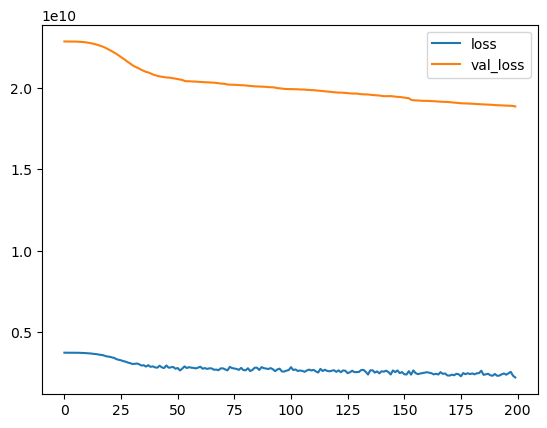

In [30]:
losses.plot()


In [45]:
X_test.shape

(164, 3, 166)

In [46]:
predictions = model.predict(X_test)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 3, 166), dtype=float32). Expected shape (None, 166), but input has incompatible shape (32, 3, 166)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 3, 166), dtype=float32)
  • training=False
  • mask=None

NameError: name 'predictions' is not defined

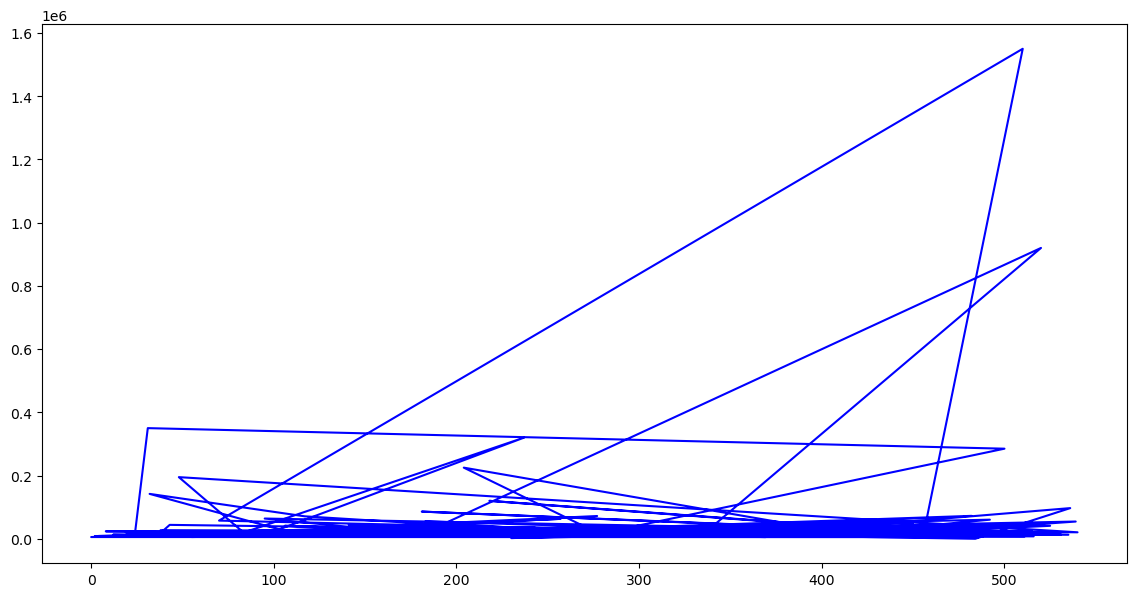

In [47]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Giá trị thực tế', color='blue')
plt.plot(predictions, label='Giá trị dự đoán', color='orange')
plt.xlabel('Sample')
plt.ylabel('Price Absolute')
plt.title('So sánh giữa giá trị thực tế và giá trị dự đoán')
plt.legend()
plt.show()


In [93]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score


In [99]:
X_test


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [104]:
predictions = model.predict(X_test)


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [101]:
mean_absolute_error(y_test,predictions)


24072.432508680555

In [102]:
np.sqrt(mean_squared_error(y_test,predictions))


32892.70126019844

In [103]:
explained_variance_score(y_test,predictions)


0.24592698629170628

In [65]:
data['price_absolute'].mean()


33620.150251585976

ValueError: x and y must be the same size

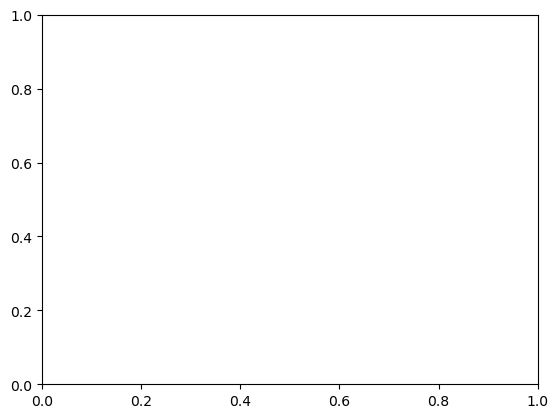

In [105]:
from matplotlib import pyplot as plt

# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

In [67]:
single_house = data.drop('price_absolute',axis=1).iloc[1]


In [66]:
single_house

province                   1
district                   5
price_unit                 1
price_value             22.0
area                   132.0
                       ...  
street_ngõ Viện Máy    False
street_Đông Quan       False
street_Đường 800A      False
street_Đồng Bát        False
street_Đỗ Quang        False
Name: 1, Length: 183, dtype: object

In [67]:
single_house = single_house.astype(np.float32)


In [68]:
single_house

province                 1.0
district                 5.0
price_unit               1.0
price_value             22.0
area                   132.0
                       ...  
street_ngõ Viện Máy      0.0
street_Đông Quan         0.0
street_Đường 800A        0.0
street_Đồng Bát          0.0
street_Đỗ Quang          0.0
Name: 1, Length: 183, dtype: float32

In [69]:
data.iloc[1]

province                     1
district                     5
price_unit                   1
price_value               22.0
price_absolute         22000.0
                        ...   
street_ngõ Viện Máy      False
street_Đông Quan         False
street_Đường 800A        False
street_Đồng Bát          False
street_Đỗ Quang          False
Name: 1, Length: 184, dtype: object